# Similarity model

## Prepare dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2, os

In [ ]:
predefined_classes_file = open('/content/drive/MyDrive/StopFundWar/predefined_classes.txt', 'r')
predefined_classes = [line.replace('\n', '') for line in predefined_classes_file.readlines()]
classes_num = len(predefined_classes)

In [ ]:
MAX_NUMBER_OF_SAMPLES_PER_CLASS = 6

In [ ]:
distribution = {}
for n_f, folder in enumerate(os.listdir('/content/drive/MyDrive/StopFundWar/Split_Data')):
    if 'ipynb_checkpoints' in folder:
      continue
    distribution[folder] = []
    if n_f % 10 == 0:
        print(n_f, '/', 110)
    train_files = os.listdir(f'/content/drive/MyDrive/StopFundWar/Split_Data/{folder}/annotations/train')
    for i, name  in enumerate(train_files):
      f = open(f'/content/drive/MyDrive/StopFundWar/Split_Data/{folder}/annotations/train/' + name, 'r')
      lines = f.readlines()
      f.close()
      if len(lines) == 1:
        distribution[folder].append(('.'.join(name.split('.')[:-1]), f'/content/drive/MyDrive/StopFundWar/Split_Data/{folder}/annotations/train/'))
      if len(distribution[folder]) > MAX_NUMBER_OF_SAMPLES_PER_CLASS - 1:
        break

0 / 110
10 / 110
20 / 110
30 / 110
40 / 110
50 / 110
60 / 110
70 / 110
80 / 110
90 / 110
100 / 110


In [ ]:
import numpy as np

In [ ]:
pairImages = []
pairLabels = []
for cl in distribution.keys():
  if not distribution[cl]:
    continue
  if len(pairImages) % 100 == 0:
        print(len(pairImages), '/', 2100)
  images = []
  for dist in distribution[cl]:
    if os.path.exists(dist[1].replace('annotations', 'images') + dist[0] + '.jpg'):
      im_1 = cv2.imread(dist[1].replace('annotations', 'images') + dist[0] + '.jpg')
    elif os.path.exists(dist[1].replace('annotations', 'images') + dist[0] + '.jpeg'):
      im_1 = cv2.imread(dist[1].replace('annotations', 'images') + dist[0] + '.jpeg')
    elif os.path.exists(dist[1].replace('annotations', 'images') + dist[0] + '.png'):
      im_1 = cv2.imread(dist[1].replace('annotations', 'images') + dist[0] + '.png')
    f = open(dist[1] + dist[0] + '.txt', 'r')
    lines = f.readlines()
    f.close()
    h, w = im_1.shape[:2]
    cl_, c_x, c_y, w_, h_ = tuple(map(float, lines[0].split()))
    im_1 = im_1[int(c_y*h) -int(h*h_/2):int(c_y*h) +int(h*h_/2), int(c_x*w) -int(w*w_/2):int(c_x*w) +int(w*w_/2)]
    #print(cl, int(c_y*h) -int(h*h_/2),int(c_y*h) +int(h*h_/2), int(c_x*w) -int(w*w_/2),int(c_x*w) +int(w*w_/2))
    _h, _w = im_1.shape[:2]
    im_1_ = np.ones((100, 100, 3), dtype=np.uint8)*255
    if _h > _w:
      im_1 = cv2.resize(im_1, ( int(100/_h*_w) if int(100/_h*_w)%2==0 else int(100/_h*_w) + 1, 100))
      im_1_[:, 50-im_1.shape[1]//2:50+im_1.shape[1]//2] = im_1
    else:
      im_1 = cv2.resize(im_1, (100, int(100/_w*_h) if int(100/_w*_h)%2==0 else int(100/_w*_h) + 1))
      im_1_[50-im_1.shape[0]//2:50+im_1.shape[0]//2, :] = im_1
    images.append(im_1_.astype(np.float32)/255)
  for i, im_l in enumerate(images):
    for j, im_r in enumerate(images):
      pairImages.append([im_l, im_r])
      pairLabels.append([1])

0 / 2100
900 / 2100
1800 / 2100
2700 / 2100
3600 / 2100


In [ ]:
import random

In [ ]:
original_len = len(pairImages)

In [ ]:
train_idx = random.sample(range(original_len), int(original_len*0.7))

In [ ]:
pairTrain = np.zeros((len(train_idx)*2, 2, 100, 100, 3), dtype=np.float32)
labelTrain =  np.zeros((len(train_idx)*2, 1), dtype=np.float32)
pairTest = np.zeros(((original_len - len(train_idx))*2, 2, 100, 100, 3), dtype=np.float32)
labelTest =  np.zeros(((original_len - len(train_idx))*2, 1), dtype=np.float32)

In [ ]:
for i, idx in enumerate(train_idx):
  pairTrain[i] = np.array([pairImages[idx]])
  labelTrain[i] = np.array([pairLabels[idx]])
cc = 0
for i, idx in enumerate(range(original_len)):
  if idx not in train_idx:
    pairTest[cc] = np.array([pairImages[idx]])
    labelTest[cc] = np.array([pairLabels[idx]])
    cc+=1

In [ ]:
len(pairTrain), len(labelTrain), len(pairTest), len(labelTest)

(2120, 2120, 910, 910)

In [ ]:
original_len

1515

In [ ]:
len(train_idx)

1060

In [ ]:
cc=len(train_idx) 
for i, im in enumerate(pairTrain[:len(train_idx)]):
  for j in random.sample(range(i+1,len(train_idx)), min(len(train_idx)-i-2, 15)):
    #pairTrain = np.append(pairTrain, np.array([[im[0], j[0]]]), axis=0)
    pairTrain[cc] = np.array([[im[0], pairTrain[j][0]]])
    cc+=1
    if cc >= len(pairTrain):
      break
  if cc >= len(pairTrain):
      break

cc=original_len - len(train_idx) 
for i, im in enumerate(pairTest[:original_len-len(train_idx)]):
  for j in random.sample(range(i+1, len(train_idx)), min(len(train_idx)-i-2, 7)):
    pairTest[cc] = np.array([[im[0], pairTrain[j][0]]])
    cc+=1
    if cc >= len(pairTest):
      break
  if cc >= len(pairTest):
      break


'    pairTest.append([im[0], j[0]])\n    pairTest.append([im[0], j[1]])\n    pairTest.append([im[1], j[0]])\n    pairTest.append([im[1], j[1]])\n    labelTest.append([0])\n    labelTest.append([0])\n    labelTest.append([0])\n    labelTest.append([0])\n  \npairTrain = np.array(pairTrain, dtype=np.float32)\nlabelTrain = np.array(labelTrain)\npairTest = np.array(pairTest, dtype=np.float32)\nlabelTest = np.array(labelTest)'

In [ ]:
pairTrain.shape, labelTrain.shape, pairTest.shape, labelTest.shape

((5090, 2, 100, 100, 3), (5090, 1), (2182, 2, 100, 100, 3), (2182, 1))

### Show train pairs

In [ ]:
import matplotlib.pyplot as plt


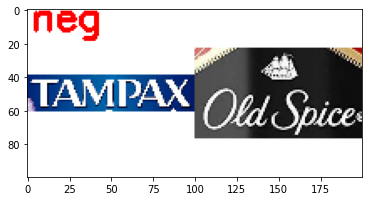

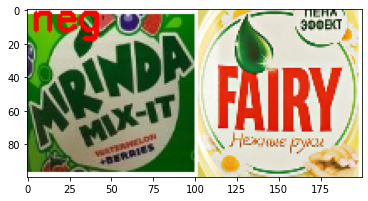

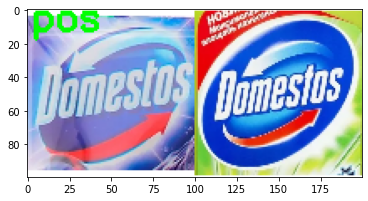

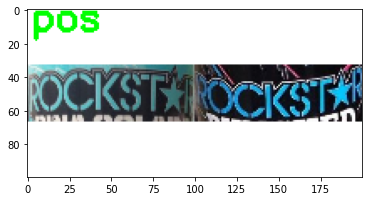

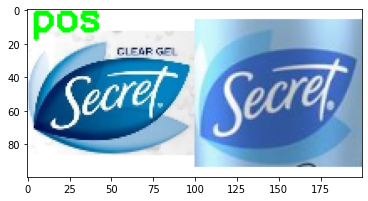

In [ ]:
for i in np.random.choice(np.arange(0, len(pairTrain)), size=(5,)):
	# grab the current image pair and label
	imageA = pairTrain[i][0]
	imageB = pairTrain[i][1]
	label = labelTrain[i]
	# to make it easier to visualize the pairs and their positive or
	# negative annotations, we're going to "pad" the pair with four
	# pixels along the top, bottom, and right borders, respectively
	output = np.zeros((100, 200,3), dtype=np.float32)
	pair = np.hstack([imageA, imageB])
	output = pair
	# set the text label for the pair along with what color we are
	# going to draw the pair in (green for a "positive" pair and
	# red for a "negative" pair)
	text = "neg" if label[0] == 0 else "pos"
	color = (0, 0, 1) if label[0] == 0 else (0, 1, 0)
	cv2.putText(output, text, (2, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)
	# add the pair visualization to our list of output images
	plt.imshow(output[:,:,::-1]);plt.show()

## Define model

In [ ]:
# specify the shape of the inputs for our network
IMG_SHAPE = (100, 100, 3)
# specify the batch size and number of epochs
BATCH_SIZE = 16
EPOCHS = 100

In [ ]:
MODEL_PATH = "siamese_model"
PLOT_PATH = "plot.png"

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

In [ ]:
def build_siamese_model(inputShape, embeddingDim=128):
	# specify the inputs for the feature extractor network
	inputs = Input(inputShape)
	# define the first set of CONV => RELU => POOL => DROPOUT layers
	# For variant 1
	"""x = Conv2D(32, (7, 7), padding="same", activation="relu")(inputs)
	x = MaxPooling2D(pool_size=(2, 2))(x)
	x = Dropout(0.3)(x)"""
	# second set of CONV => RELU => POOL => DROPOUT layers
	# For variant 1 x = Conv2D(64, (5, 5), padding="same", activation="relu")(x)
	x = Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
	x = MaxPooling2D(pool_size=2)(x)
	x = Dropout(0.3)(x)
	# third set of CONV => RELU => POOL => DROPOUT layers
	# For variant 1 x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
	x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Dropout(0.3)(x)
 
  # prepare the final outputs
	pooledOutput = GlobalAveragePooling2D()(x)
	outputs = Dense(embeddingDim)(pooledOutput)
	# build the model
	model = Model(inputs, outputs)
	# return the model to the calling function
	return model

In [ ]:
featureExtractor = build_siamese_model(IMG_SHAPE)

In [ ]:
featureExtractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      4736      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                         

In [ ]:
import tensorflow.keras.backend as K

In [ ]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [ ]:
def plot_training(H, plotPath):
  # construct a plot that plots and saves the training history
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(H.history["loss"], label="train_loss")
  plt.plot(H.history["val_loss"], label="val_loss")
  if "accuracy" in H.history.keys():
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend(loc="lower left")
  plt.savefig(plotPath)

In [ ]:
import tensorflow as tf

def contrastive_loss(y, preds, margin=1):
	# explicitly cast the true class label data type to the predicted
	# class label data type (otherwise we run the risk of having two
	# separate data types, causing TensorFlow to error out)
	y = tf.cast(y, preds.dtype)

	# calculate the contrastive loss between the true labels and
	# the predicted labels
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

	# return the computed contrastive loss to the calling function
	return loss

In [ ]:
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

In [ ]:
from tensorflow.keras.layers import Lambda

In [ ]:
# For variant 1
#distance = Lambda(euclidean_distance)([featsA, featsB])
#outputs = Dense(1, activation="sigmoid")(distance)
#model = Model(inputs=[imgA, imgB], outputs=outputs)


# For variant 2
#distance = Lambda(euclidean_distance)([featsA, featsB])
#outputs = tf.keras.activations.sigmoid(distance)
#model = Model(inputs=[imgA, imgB], outputs=outputs)

# For variant 3
distance = Lambda(euclidean_distance)([featsA, featsB])
model = Model(inputs=[imgA, imgB], outputs=distance)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 128)          47040       ['input_4[0][0]',                
                                                                  'input_5[0][0]']          

## Training

In [ ]:
# For variant 1
#model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# For variant 2-3
model.compile(loss=contrastive_loss, optimizer="adam")

# train the model
history = model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
                    validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    verbose=True)

Epoch 1/100
319/319 [==============================] - 8s 24ms/step - loss: 0.0763 - val_loss: 0.0956
Epoch 2/100
319/319 [==============================] - 7s 21ms/step - loss: 0.0719 - val_loss: 0.0850
Epoch 3/100
319/319 [==============================] - 7s 21ms/step - loss: 0.0707 - val_loss: 0.0957
Epoch 4/100
319/319 [==============================] - 7s 23ms/step - loss: 0.0698 - val_loss: 0.0807
Epoch 5/100
319/319 [==============================] - 7s 21ms/step - loss: 0.0678 - val_loss: 0.0820
Epoch 6/100
319/319 [==============================] - 7s 22ms/step - loss: 0.0705 - val_loss: 0.0845
Epoch 7/100
319/319 [==============================] - 7s 22ms/step - loss: 0.0709 - val_loss: 0.0843
Epoch 8/100
319/319 [==============================] - 7s 22ms/step - loss: 0.0687 - val_loss: 0.0875
Epoch 9/100
319/319 [==============================] - 7s 21ms/step - loss: 0.0666 - val_loss: 0.0959
Epoch 10/100
319/319 [==============================] - 7s 21ms/step - loss: 0.069

## Save model

In [ ]:
model.save(MODEL_PATH+'_2')
model.save(f'{MODEL_PATH}_2/{MODEL_PATH}_2.h5')

INFO:tensorflow:Assets written to: siamese_model_2/assets


In [ ]:
!zip -r siamese_model_2.zip /content/siamese_model_2/

updating: content/siamese_model_2/ (stored 0%)
updating: content/siamese_model_2/saved_model.pb (deflated 89%)
updating: content/siamese_model_2/variables/ (stored 0%)
updating: content/siamese_model_2/variables/variables.data-00000-of-00001 (deflated 22%)
updating: content/siamese_model_2/variables/variables.index (deflated 63%)
updating: content/siamese_model_2/keras_metadata.pb (deflated 92%)
updating: content/siamese_model_2/siamese_model_2.h5 (deflated 25%)
updating: content/siamese_model_2/assets/ (stored 0%)


## Plot metric and loss

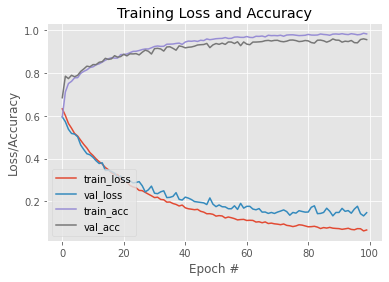

In [ ]:
# For variant 1
# plot the training history
plot_training(history, PLOT_PATH)

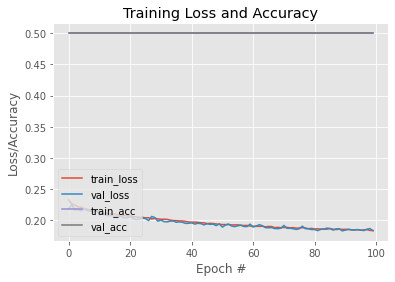

In [ ]:
# For variant 2
# plot the training history
plot_training(history, PLOT_PATH)

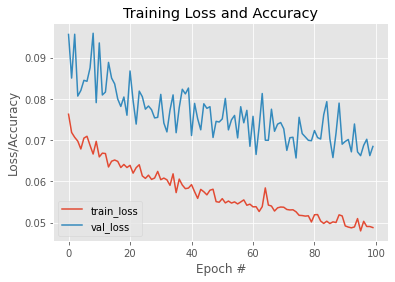

In [ ]:
# For variant 3
# plot the training history
plot_training(history, PLOT_PATH)

## Test Model

In [ ]:
from tensorflow.keras.models import load_model
model_ = load_model(MODEL_PATH+'_2', compile=False)

In [ ]:
import time

### For variant 1 (model return image similarity)

0.06494736671447754


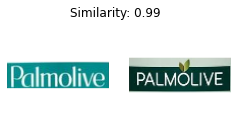

0.11838340759277344


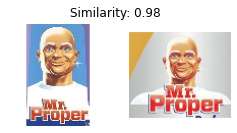

0.08352279663085938


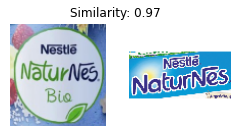

0.08390974998474121


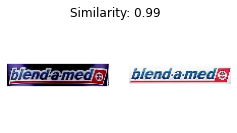

0.07135152816772461


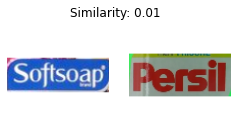

0.0686497688293457


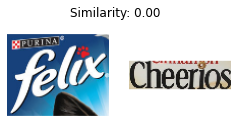

0.10222911834716797


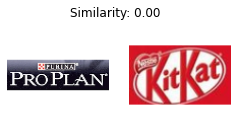

0.06567168235778809


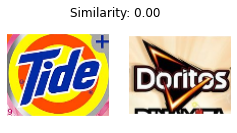

In [ ]:
for (i, (imageA, imageB)) in enumerate(pairTest[[0,300,600,900,1300,1600, 1900, 2100]]):
    # create a copy of both the images for visualization purpose
    origA = imageA.copy()
    origB = imageB.copy()
    # add a batch dimension to both images
    imageA = np.expand_dims(imageA, axis=0)
    imageB = np.expand_dims(imageB, axis=0)
    # use our siamese model to make predictions on the image pair,
    # indicating whether or not the images belong to the same class
    s_t = time.time()
    preds = model.predict([imageA, imageB])
    print(time.time()-s_t)
    proba = preds[0][0]

    fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
    plt.suptitle("Similarity: {:.2f}".format(proba))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(origA[:,:,::-1], cmap=plt.cm.gray)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(origB[:,:,::-1], cmap=plt.cm.gray)
    plt.axis("off")
    # show the plot
    plt.show()

### For variant 2-3 (model return image vector)

In [ ]:
for layer in model.layers[2].layers:
    print(layer.name, layer)

input_1 <keras.engine.input_layer.InputLayer object at 0x7fb2fc6eb350>
conv2d <keras.layers.convolutional.Conv2D object at 0x7fb2fc738e50>
max_pooling2d <keras.layers.pooling.MaxPooling2D object at 0x7fb2fc6f6ad0>
dropout <keras.layers.core.dropout.Dropout object at 0x7fb2fbe37490>
conv2d_1 <keras.layers.convolutional.Conv2D object at 0x7fb2fbe1db10>
max_pooling2d_1 <keras.layers.pooling.MaxPooling2D object at 0x7fb2f0238250>
dropout_1 <keras.layers.core.dropout.Dropout object at 0x7fb2f02a8050>
global_average_pooling2d <keras.layers.pooling.GlobalAveragePooling2D object at 0x7fb2f023f890>
dense <keras.layers.core.dense.Dense object at 0x7fb2f023f210>


In [ ]:
for layer in featureExtractor.layers:
    print(layer.name, layer)

input_1 <keras.engine.input_layer.InputLayer object at 0x7fb2fc6eb350>
conv2d <keras.layers.convolutional.Conv2D object at 0x7fb2fc738e50>
max_pooling2d <keras.layers.pooling.MaxPooling2D object at 0x7fb2fc6f6ad0>
dropout <keras.layers.core.dropout.Dropout object at 0x7fb2fbe37490>
conv2d_1 <keras.layers.convolutional.Conv2D object at 0x7fb2fbe1db10>
max_pooling2d_1 <keras.layers.pooling.MaxPooling2D object at 0x7fb2f0238250>
dropout_1 <keras.layers.core.dropout.Dropout object at 0x7fb2f02a8050>
global_average_pooling2d <keras.layers.pooling.GlobalAveragePooling2D object at 0x7fb2f023f890>
dense <keras.layers.core.dense.Dense object at 0x7fb2f023f210>


In [ ]:
featureExtractor.set_weights(model.layers[2].get_weights())

In [ ]:
featureExtractor(imageA)

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[-0.10916194,  0.11730854, -1.1327872 , -0.3043285 ,  0.74911165,
         1.4191357 , -0.54187405,  0.08008791,  0.1519989 ,  0.533224  ,
         0.28165355, -1.079387  , -0.3433678 , -0.40294084, -1.2664628 ,
         1.4238434 ,  1.0067879 , -0.31120533, -1.4382876 ,  0.9409415 ,
         0.5118394 ,  0.5116252 , -0.894451  ,  0.06776363, -0.7129036 ,
        -1.1496544 ,  0.47887114,  0.36054215, -1.01626   , -0.10235866,
        -0.58855313,  0.82482237, -0.823056  ,  0.8388362 ,  0.18858607,
         0.75077736, -0.06848457,  0.2626247 , -0.6730022 ,  0.45696026,
         0.06172995, -1.252664  , -0.84711397,  0.43192214,  1.4582148 ,
        -1.08048   , -0.41365647,  0.76877034,  0.5710553 , -0.59416294,
        -0.714155  ,  1.0118762 , -0.56525165, -0.13871916, -0.65149754,
        -0.29935595, -0.8404258 , -1.0698673 ,  0.8560964 , -0.32713926,
        -0.24883942,  0.19149388, -1.1902903 ,  0.37443823, -0.37905085,
 

#### For variant 2

0.004278421401977539
0.008802413940429688


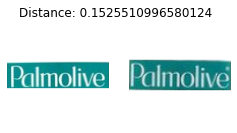

0.0059986114501953125
0.015652894973754883


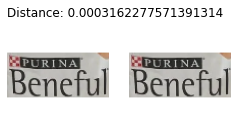

0.005246400833129883
0.009508609771728516


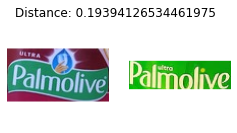

0.0063817501068115234
0.01078939437866211


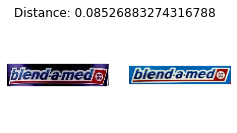

0.008404254913330078
0.012576103210449219


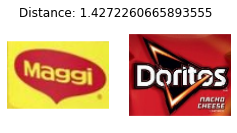

0.009365081787109375
0.013665199279785156


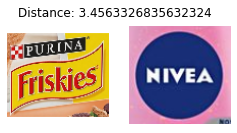

0.006728649139404297
0.013760805130004883


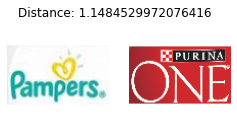

0.004679679870605469
0.011840581893920898


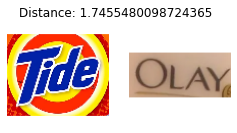

In [ ]:
for (i, (imageA, imageB)) in enumerate(pairTest[[0,300,600,900,1300,1600, 1900, 2100]]):
    # create a copy of both the images for visualization purpose
    origA = imageA.copy()
    origB = imageB.copy()
    # add a batch dimension to both images
    imageA = np.expand_dims(imageA, axis=0)
    imageB = np.expand_dims(imageB, axis=0)
    # use our siamese model to make predictions on the image pair,
    # indicating whether or not the images belong to the same class
    s_t = time.time()
    featuresA = featureExtractor(imageA)
    print(time.time()-s_t)
    featuresB = featureExtractor(imageB)
    distance = euclidean_distance([featuresA, featuresB]).numpy()[0][0]
    print(time.time()-s_t)

    fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
    plt.suptitle("Distance: {}".format(distance))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(origA[:,:,::-1], cmap=plt.cm.gray)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(origB[:,:,::-1], cmap=plt.cm.gray)
    plt.axis("off")
    # show the plot
    plt.show()

#### For variant 3

0.0073816776275634766
0.014051437377929688


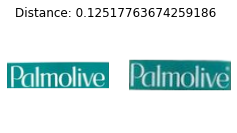

0.008848190307617188
0.01703953742980957


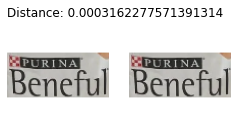

0.005049705505371094
0.011505365371704102


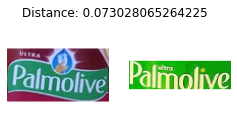

0.004971027374267578
0.012015342712402344


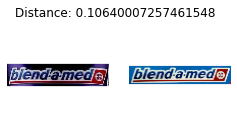

0.004626274108886719
0.011878490447998047


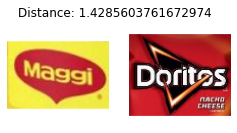

0.010946989059448242
0.015801429748535156


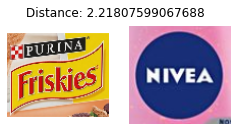

0.0043163299560546875
0.011074066162109375


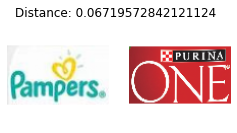

0.005631208419799805
0.011487722396850586


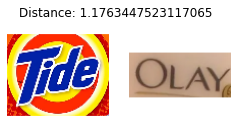

In [ ]:
for (i, (imageA, imageB)) in enumerate(pairTest[[0,300,600,900,1300,1600, 1900, 2100]]):
    # create a copy of both the images for visualization purpose
    origA = imageA.copy()
    origB = imageB.copy()
    # add a batch dimension to both images
    imageA = np.expand_dims(imageA, axis=0)
    imageB = np.expand_dims(imageB, axis=0)
    # use our siamese model to make predictions on the image pair,
    # indicating whether or not the images belong to the same class
    s_t = time.time()
    featuresA = featureExtractor(imageA)
    print(time.time()-s_t)
    featuresB = featureExtractor(imageB)
    distance = euclidean_distance([featuresA, featuresB]).numpy()[0][0]
    print(time.time()-s_t)

    fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
    plt.suptitle("Distance: {}".format(distance))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(origA[:,:,::-1], cmap=plt.cm.gray)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(origB[:,:,::-1], cmap=plt.cm.gray)
    plt.axis("off")
    # show the plot
    plt.show()

In [ ]:
imageA, imageB  =pairTest[2100]
# add a batch dimension to both images
imageA = np.expand_dims(imageA, axis=0)
imageB = np.expand_dims(imageB, axis=0)
# use our siamese model to make predictions on the image pair,
# indicating whether or not the images belong to the same class
s_t = time.time()
featuresA = featureExtractor(imageA)
featuresB = featureExtractor(imageB)

In [ ]:
euclidean_distance([featuresA, featuresB]).numpy()

array([[1.1763448]], dtype=float32)

In [ ]:
tf.math.sigmoid(euclidean_distance([featuresA, featuresB]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.76429]], dtype=float32)>